In [7]:
# !pip install seaborn


In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.stats as stats
from collections import OrderedDict
import matplotlib.ticker as ticker
from scipy.stats import pearsonr, norm, gmean, sem, median_abs_deviation


In [38]:
def calc_within_subj_variance(df, task_prefix):
	"""Calculate within-subject variance for all subjects for a given task prefix."""
	task_cols = [col for col in df.columns if col.startswith(task_prefix)]
	# Calculate variance for each subject (row) across repeats (columns)
	return df[task_cols].var(axis=1, ddof=1).mean()

def calc_between_subj_variance(df, task_prefix):
	"""Calculate between-subject variance for a given task prefix."""
	task_cols = [col for col in df.columns if col.startswith(task_prefix)]
	# Average across repeats for each subject
	subj_means = df[task_cols].mean(axis=1)
	# Variance between subjects
	return np.nanvar(subj_means, ddof=1)

def calc_mean(df, task_prefix):
	"""Calculate mean for all thresholds for a given task prefix."""
	task_cols = [col for col in df.columns if col.startswith(task_prefix)]
	# first average across repeats for each subject
	subj_means = df[task_cols].mean(axis=1)
	# then average across subjects
	return np.nanmean(subj_means)

def compute_noise_ceiling(df, task_prefix):
	"""
	Reference: Diedrichsen
	Computes the noise ceiling for a set of repeated measurements.
	Uses split-half reliability across multiple measurements and the geometric mean formula.
	"""
	task_cols = [col for col in df.columns if col.startswith(task_prefix)]
	measurements = df[task_cols]

	n_measurements = measurements.shape[1]

	first_half = measurements.iloc[:, :n_measurements//2]
	last_half = measurements.iloc[:, n_measurements//2:]
	odd_half = measurements.iloc[:, 1::2]
	even_half = measurements.iloc[:, 0::2]

	# Compute means while ignoring NaN
	mean_first_half = np.mean(first_half, axis=1)
	mean_last_half = np.mean(last_half, axis=1)

	# Filter out rows where either mean is NaN
	valid_indices = ~np.isnan(mean_first_half) & ~np.isnan(mean_last_half)
	# if len(valid_indices) < len(measurements):
	# 	print(f"Some data was excluded due to NaN values for task {task_prefix}")

	# Compute Pearson correlation only for valid rows
	r_firstLast, _ = pearsonr(mean_first_half[valid_indices], mean_last_half[valid_indices])

	# Repeat for odd/even halves
	mean_odd_half = np.mean(odd_half, axis=1)
	mean_even_half = np.mean(even_half, axis=1)

		
	valid_indices = ~np.isnan(mean_odd_half) & ~np.isnan(mean_even_half)
	r_oddEven, _ = pearsonr(mean_odd_half[valid_indices], mean_even_half[valid_indices])

	# Compute the split-half reliability as the geometric mean
	print(r_firstLast, r_oddEven)
	r_i = np.sqrt(r_firstLast * r_oddEven)

	# Apply the extrapolation formula for multiple measurements
	N = 2
	r_m = (N * r_i) / ((r_i * (N - 1)) + 1)

	return r_i, r_m


def gather_results(df, task_prefixes):
	"""Gather results for within and between subject variance."""
	results = []
	for task in task_prefixes:

		
		within_var = calc_within_subj_variance(df, task)
		between_var = calc_between_subj_variance(df, task)
		mean_val = calc_mean(df, task)
		r_i, r_ceiling = compute_noise_ceiling(df, task)
		
		results.append({'task': task, 'within_subj_variance': within_var, 
						'btw_subj_variance': between_var, 'mean': mean_val,
						'r_i': r_i, 'r_ceiling': r_ceiling})
	return pd.DataFrame(results)

# Kurzawski et al. (2025, Nature Comm) Data

In [10]:
dir_natCom = 'data/kurzawski_2025_data.csv'
natCom_data = pd.read_csv(dir_natCom)
print(natCom_data.columns)

Index(['V1_R1_lh', 'V1_R2_lh', 'V2_R1_lh', 'V2_R2_lh', 'V3_R1_lh', 'V3_R2_lh',
       'V4_R1_lh', 'V4_R2_lh', 'V1_R1_rh', 'V1_R2_rh', 'V2_R1_rh', 'V2_R2_rh',
       'V3_R1_rh', 'V3_R2_rh', 'V4_R1_rh', 'V4_R2_rh', 'NLetters',
       'NLetters_S1', 'NLetters_S2', 'NLetters_RightMeridian',
       'NLetters_LeftMeridian', 'crowdingDist_Ecc5_Left_Meridian_Ses1',
       'crowdingDist_Ecc5_Left_Meridian_Ses2',
       'crowdingDist_Ecc5_Lower_Meridian_Ses1',
       'crowdingDist_Ecc5_Lower_Meridian_Ses2',
       'crowdingDist_Ecc5_Right_Meridian_Ses1',
       'crowdingDist_Ecc5_Right_Meridian_Ses2',
       'crowdingDist_Ecc5_Upper_Meridian_Ses1',
       'crowdingDist_Ecc5_Upper_Meridian_Ses2',
       'crowdingDist_Ecc10_Left_Meridian_Ses1',
       'crowdingDist_Ecc10_Left_Meridian_Ses2',
       'crowdingDist_Ecc10_Lower_Meridian_Ses1',
       'crowdingDist_Ecc10_Lower_Meridian_Ses2',
       'crowdingDist_Ecc10_Right_Meridian_Ses1',
       'crowdingDist_Ecc10_Right_Meridian_Ses2',
       'crowd

In [ ]:
# Create a new DataFrame with columns that start with 'crowdingDist'
natCom_crowding = natCom_data.filter(like='crowdingDist')
natCom_crowding_log = natCom_crowding.apply(np.log10)

natCom_crowding_avgRL_log = pd.DataFrame({
    'crowding_Ecc5_RL_Ses1': (natCom_crowding_log['crowdingDist_Ecc5_Left_Meridian_Ses1'] +
                              natCom_crowding_log['crowdingDist_Ecc5_Right_Meridian_Ses1']) / 2,
	'crowding_Ecc5_RL_Ses2': (natCom_crowding_log['crowdingDist_Ecc5_Left_Meridian_Ses2'] +
							  natCom_crowding_log['crowdingDist_Ecc5_Right_Meridian_Ses2']) / 2,
    'crowding_Ecc10_RL_Ses1': (natCom_crowding_log['crowdingDist_Ecc10_Left_Meridian_Ses1'] +
							  natCom_crowding_log['crowdingDist_Ecc10_Right_Meridian_Ses1']) / 2,
    'crowding_Ecc10_RL_Ses2': (natCom_crowding_log['crowdingDist_Ecc10_Left_Meridian_Ses2'] +
							  natCom_crowding_log['crowdingDist_Ecc10_Right_Meridian_Ses2']) / 2
})

natCom_crowding_avgRL = pd.DataFrame({
    'crowding_Ecc5_RL_Ses1': 10 ** ((natCom_crowding_log['crowdingDist_Ecc5_Left_Meridian_Ses1'] +
                              natCom_crowding_log['crowdingDist_Ecc5_Right_Meridian_Ses1']) / 2),
	'crowding_Ecc5_RL_Ses2': 10 ** ((natCom_crowding_log['crowdingDist_Ecc5_Left_Meridian_Ses2'] +
							  natCom_crowding_log['crowdingDist_Ecc5_Right_Meridian_Ses2']) / 2),
    'crowding_Ecc10_RL_Ses1': 10 ** ((natCom_crowding_log['crowdingDist_Ecc10_Left_Meridian_Ses1'] +
							  natCom_crowding_log['crowdingDist_Ecc10_Right_Meridian_Ses1']) / 2),
    'crowding_Ecc10_RL_Ses2': 10 ** ((natCom_crowding_log['crowdingDist_Ecc10_Left_Meridian_Ses2'] +
							  natCom_crowding_log['crowdingDist_Ecc10_Right_Meridian_Ses2']) / 2)
})



In [52]:
crowding_cols = [col for col in natCom_data.columns if col.startswith('crowdingDist')]
crowding_geomean = natCom_data[crowding_cols].apply(gmean, axis=1)

In [12]:
# Create a new DataFrame with the summed columns
natCom_data_map_sum = pd.DataFrame({
    'V1_R1': natCom_data['V1_R1_rh'] + natCom_data['V1_R1_lh'],
    'V1_R2': natCom_data['V1_R2_rh'] + natCom_data['V1_R2_lh'],
    'V2_R1': natCom_data['V2_R1_rh'] + natCom_data['V2_R1_lh'],
    'V2_R2': natCom_data['V2_R2_rh'] + natCom_data['V2_R2_lh'],
    'V3_R1': natCom_data['V3_R1_rh'] + natCom_data['V3_R1_lh'],
    'V3_R2': natCom_data['V3_R2_rh'] + natCom_data['V3_R2_lh'],
    'V4_R1': natCom_data['V4_R1_rh'] + natCom_data['V4_R1_lh'],
    'V4_R2': natCom_data['V4_R2_rh'] + natCom_data['V4_R2_lh']
})
natCom_data_map_sum_log = natCom_data_map_sum.apply(np.log10)


## Map size data

In [43]:
df_for_analysis = natCom_data_map_sum.copy()
brain_prefixes = ['V1', 'V2', 'V3', 'V4']
                                  
brain_df = gather_results(df_for_analysis, brain_prefixes)
display(brain_df)

variance_df = brain_df

0.9408814616181638 0.9408814616181637
0.8761465093529249 0.8761465093529252
0.7473098357812088 0.7473098357812088
0.7251480721469798 0.7251480721469798


,task,within_subj_variance,btw_subj_variance,mean,r_i,r_ceiling
0,V1,17821.877551,282877.582908,2864.020408,0.940881,0.969540
1,V2,20629.234694,147972.198980,2735.765306,0.876147,0.933985
2,V3,40247.438776,110570.730442,2098.255102,0.747310,0.855383
3,V4,16759.010204,44731.228954,915.397959,0.725148,0.840679


## Crowding data

In [47]:
df_for_analysis = natCom_crowding_avgRL.copy()
task_prefixes = ['crowding_Ecc5_RL', 'crowding_Ecc10_RL']

crowding_natcom_df = gather_results(df_for_analysis, task_prefixes)
display(crowding_natcom_df)

variance_df = pd.concat([variance_df, crowding_natcom_df], ignore_index=True)

0.8425707066898213 0.8425707066898213
0.7805692110204995 0.7805692110204996


,task,within_subj_variance,btw_subj_variance,mean,r_i,r_ceiling
0,crowding_Ecc5_RL,0.023985,0.100356,1.070673,0.842571,0.914560
1,crowding_Ecc10_RL,0.111349,0.458027,2.562647,0.780569,0.876764


In [56]:
df_for_analysis = natCom_data.copy()
task_prefixes = ['crowdingDist']

crowding_natcom_all_df = gather_results(df_for_analysis, task_prefixes)
display(crowding_natcom_all_df)
variance_df = pd.concat([variance_df, crowding_natcom_all_df], ignore_index=True)


0.7272469135391622 0.9247632448830202


,task,within_subj_variance,btw_subj_variance,mean,r_i,r_ceiling
0,crowdingDist,1.610518,0.117175,2.289848,0.82008,0.901147


## Correlate crowding and V4

In [60]:
V4_size = 10 ** ((natCom_data_map_sum_log['V4_R1'] + natCom_data_map_sum_log['V4_R2']) / 2)
crowding_10deg = 10 ** ((natCom_crowding_avgRL_log['crowding_Ecc10_RL_Ses1'] +
                 natCom_crowding_avgRL_log['crowding_Ecc10_RL_Ses2']) / 2)

# correlate V4 and crowding
measured_corr_V4_crowding = pearsonr(V4_size, crowding_geomean)
print(f'Correlation between V4 size and crowding: {measured_corr_V4_crowding[0]:.3f}')

# get noise ceiling for crowding and V4
r_ceiling_crowding = variance_df.loc[variance_df['task'] == 'crowdingDist', 'r_ceiling'].values[0]
r_ceiling_V4 = variance_df.loc[variance_df['task'] == 'V4', 'r_ceiling'].values[0]
print(f'Noise ceiling for crowding (all measurements): {r_ceiling_crowding:.3f}')
print(f'Noise ceiling for V4 size: {r_ceiling_V4:.3f}')

# correction for noise ceiling
r_ceil = np.sqrt(r_ceiling_crowding * r_ceiling_V4)
corrected_corr_V4_crowding = measured_corr_V4_crowding[0] / r_ceil
print(f'Corrected correlation between V4 size and crowding: {corrected_corr_V4_crowding:.3f}')

Correlation between V4 size and crowding: -0.658
Noise ceiling for crowding (all measurements): 0.901
Noise ceiling for V4 size: 0.841
Corrected correlation between V4 size and crowding: -0.756


In [61]:
pd.options.display.float_format = '{:.2f}'.format
display(variance_df)

,task,within_subj_variance,btw_subj_variance,mean,r_i,r_ceiling
0,V1,17821.88,282877.58,2864.02,0.94,0.97
1,V2,20629.23,147972.20,2735.77,0.88,0.93
2,V3,40247.44,110570.73,2098.26,0.75,0.86
3,V4,16759.01,44731.23,915.40,0.73,0.84
4,crowding_Ecc5_RL,0.02,0.10,1.07,0.84,0.91
5,crowding_Ecc10_RL,0.11,0.46,2.56,0.78,0.88
6,crowdingDist,1.61,0.12,2.29,0.82,0.90


# Correlation between brain area

In [62]:
def correlation_matrix(df_data, df_r_ceiling, var_ceiling_pairs, log10_bool=True):
    """
    Create a correlation matrix for the given DataFrame and noise ceiling DataFrame.

    Parameters:
        df_data (pd.DataFrame): DataFrame containing the data to correlate.
        df_r_ceiling (pd.DataFrame): DataFrame containing the noise ceilings.
        var_ceiling_pairs (dict): Dictionary mapping variable names to their noise ceiling names.
        log10_bool (bool): Whether to apply log10 transformation to the data.

    Returns:
        pd.DataFrame: Correlation matrix with measured and corrected correlations.
    """
    df_data = df_data.copy()
    df_r_ceiling = df_r_ceiling.copy()
    results = []
    
    for var_x, var_y in itertools.combinations(df_data.columns, 2):
        print(var_x, var_y)
        r_ceiling_x = df_r_ceiling.loc[df_r_ceiling['task'] == var_ceiling_pairs[var_x], 'r_ceiling'].values[0]
        r_ceiling_y = df_r_ceiling.loc[df_r_ceiling['task'] == var_ceiling_pairs[var_y], 'r_ceiling'].values[0]
        
        result = print_measured_corrected_r(
            df_data,
            var_x=var_x,
            var_y=var_y,
            r_ceiling_x=r_ceiling_x,
            r_ceiling_y=r_ceiling_y,
            log10_bool=log10_bool
        )
        
        results.append(result)

    return pd.concat(results, ignore_index=True)

In [63]:
def long_to_square(df_long, value_col="r_measured"):
    """
    Convert your long-form correlation table into a square matrix.
    
    Parameters:
        df_long: DataFrame with columns ['var_x','var_y',...,value_col]
        value_col: 'r_measured' or 'r_corrected'
    """
    vars_all = sorted(set(df_long["var_x"]).union(df_long["var_y"]))
    R = pd.DataFrame(np.nan, index=vars_all, columns=vars_all, dtype=float)

    for _, row in df_long.iterrows():
        x, y, val = row["var_x"], row["var_y"], row[value_col]
        R.loc[x, y] = val
        R.loc[y, x] = val

    np.fill_diagonal(R.values, 1.0)
    return R

def plot_corr_heatmap(df_long, value_col="r_measured", title=None, mask_upper=True, mask_diag=True, fontSize=10):
    """
    Plot a heatmap from the long correlation table.
    
    Parameters:
        df_long: output from correlation_matrix(...)
        value_col: 'r_measured' or 'r_corrected'
        mask_upper: True = show only lower triangle for readability
    """
    R = long_to_square(df_long, value_col=value_col)

    mask = None
    if mask_upper or mask_diag:
        mask = np.zeros_like(R, dtype=bool)
        if mask_upper:
            mask[np.triu_indices_from(mask, k=1)] = True  # mask above-diagonal
        if mask_diag:
            np.fill_diagonal(mask, True)  # mask diagonal

    plt.figure(figsize=(9, 8))
    ax = sns.heatmap(
        R, annot=True, fmt=".2f", cmap="RdBu_r",
        vmin=-1, vmax=1, center=0, square=True,
        mask=mask, cbar_kws={"label": "r"},
        annot_kws={"size": fontSize}
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_title(title or f"Correlation matrix ({value_col})")
    plt.tight_layout()
    plt.show()


In [67]:
print(natCom_data_map_sum.columns)

natCom_data_map_sum['V1'] = np.mean([natCom_data_map_sum['V1_R1'], natCom_data_map_sum['V1_R2']], axis=0)
natCom_data_map_sum['V2'] = np.mean([natCom_data_map_sum['V2_R1'], natCom_data_map_sum['V2_R2']], axis=0)
natCom_data_map_sum['V3'] = np.mean([natCom_data_map_sum['V3_R1'], natCom_data_map_sum['V3_R2']], axis=0)
natCom_data_map_sum['V4'] = np.mean([natCom_data_map_sum['V4_R1'], natCom_data_map_sum['V4_R2']], axis=0)

df_for_analysis = natCom_data_map_sum[['V1', 'V2', 'V3', 'V4']].copy()
display(df_for_analysis)

Index(['V1_R1', 'V1_R2', 'V2_R1', 'V2_R2', 'V3_R1', 'V3_R2', 'V4_R1', 'V4_R2',
       'V1', 'V2', 'V3', 'V4'],
      dtype='object')


,V1,V2,V3,V4
0,3198.00,3042.50,2165.00,855.50
1,3052.00,2766.50,2053.50,1483.50
2,2823.00,2784.50,2376.00,1027.50
3,3632.50,3363.50,2510.00,767.50
4,3102.00,2802.50,2560.00,780.50
5,2506.50,2557.50,2269.50,935.50
6,2385.00,2602.00,2038.50,821.50
7,3401.50,2736.00,1695.50,936.00
8,2584.00,2814.50,1906.50,618.00
9,2488.50,3039.50,2832.50,859.00


In [68]:
var_ceiling_pairs = {
    'V1': 'V1',
    'V2': 'V2',
    'V3': 'V3',
    'V4': 'V4',
}

In [71]:
def print_measured_corrected_r(df, var_x, var_y, r_ceiling_x, r_ceiling_y, log10_bool=False):
    """
    Compute and print measured and corrected Pearson correlations between two variables.

    Parameters:
        df (pd.DataFrame): Data containing the variables.
        var_x (str): Name of the first variable (x-axis).
        var_y (str): Name of the second variable (y-axis).
        r_ceiling_x (float): Noise ceiling (reliability) for var_x.
        r_ceiling_y (float): Noise ceiling (reliability) for var_y.

    Returns:
        pd.DataFrame: Single-row dataframe with results.
    """
    df = df.copy()

    if log10_bool:
        df[var_x] = np.log10(df[var_x].where(df[var_x] > 0))
        df[var_y] = np.log10(df[var_y].where(df[var_y] > 0))
    
    # Filter for non-NaN pairs
    valid_mask = df[[var_x, var_y]].notna().all(axis=1)
    x_vals = df.loc[valid_mask, var_x]
    y_vals = df.loc[valid_mask, var_y]

    # Compute measured correlation
    r_measured, p_value = stats.pearsonr(x_vals, y_vals)

    # Compute combined noise ceiling
    r_ceiling_combined = np.sqrt(r_ceiling_x * r_ceiling_y)

    # Apply correction
    r_corrected = r_measured / r_ceiling_combined

    # Print results
    print(
        f"Correlating {var_x} vs. {var_y}:\n"
        f"  r_measured = {r_measured:.2f}\n"
        f"  r_corrected = {r_corrected:.2f}\n"
        f"  Noise ceilings: {var_x} = {r_ceiling_x:.2f}, "
        f"{var_y} = {r_ceiling_y:.2f}, combined = {r_ceiling_combined:.2f}"
    )

    # Return results in dataframe form
    return pd.DataFrame({
        'var_x': [var_x],
        'var_y': [var_y],
        'noise_ceiling_x': [r_ceiling_x],
        'noise_ceiling_y': [r_ceiling_y],
        'noise_ceiling_combined': [r_ceiling_combined],
        'r_measured': [r_measured],
        'r_corrected': [r_corrected]
    })


In [72]:
import itertools

corr_mtx_allthresh = correlation_matrix(df_for_analysis, variance_df, var_ceiling_pairs, log10_bool=True)

V1 V2
Correlating V1 vs. V2:
  r_measured = 0.62
  r_corrected = 0.65
  Noise ceilings: V1 = 0.97, V2 = 0.93, combined = 0.95
V1 V3
Correlating V1 vs. V3:
  r_measured = 0.21
  r_corrected = 0.23
  Noise ceilings: V1 = 0.97, V3 = 0.86, combined = 0.91
V1 V4
Correlating V1 vs. V4:
  r_measured = 0.12
  r_corrected = 0.14
  Noise ceilings: V1 = 0.97, V4 = 0.84, combined = 0.90
V2 V3
Correlating V2 vs. V3:
  r_measured = 0.42
  r_corrected = 0.47
  Noise ceilings: V2 = 0.93, V3 = 0.86, combined = 0.89
V2 V4
Correlating V2 vs. V4:
  r_measured = -0.01
  r_corrected = -0.02
  Noise ceilings: V2 = 0.93, V4 = 0.84, combined = 0.89
V3 V4
Correlating V3 vs. V4:
  r_measured = 0.13
  r_corrected = 0.15
  Noise ceilings: V3 = 0.86, V4 = 0.84, combined = 0.85


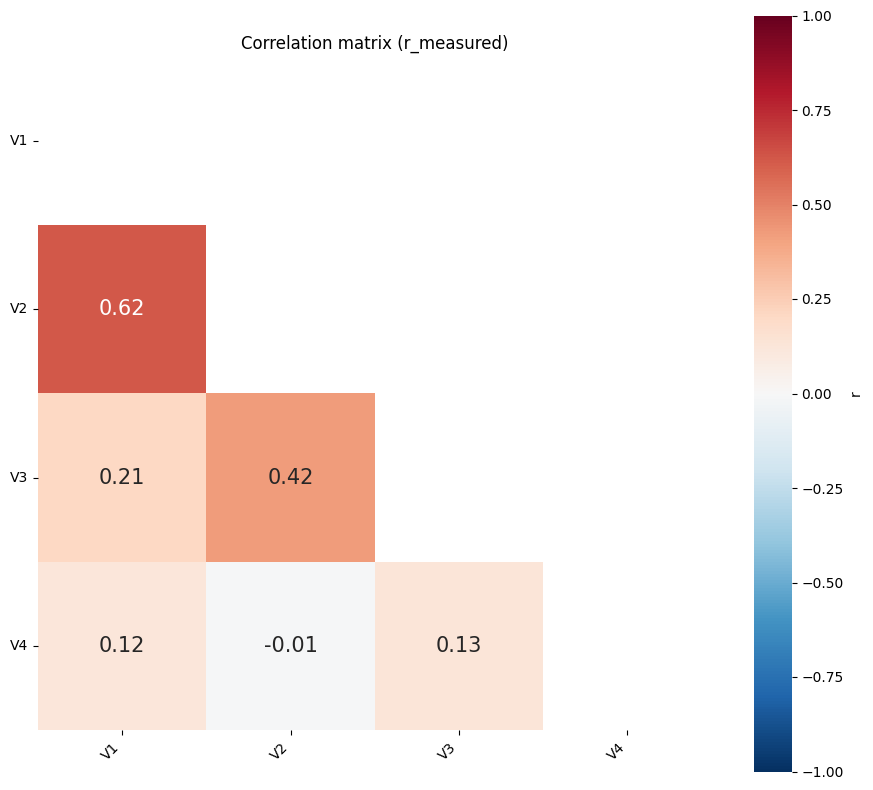

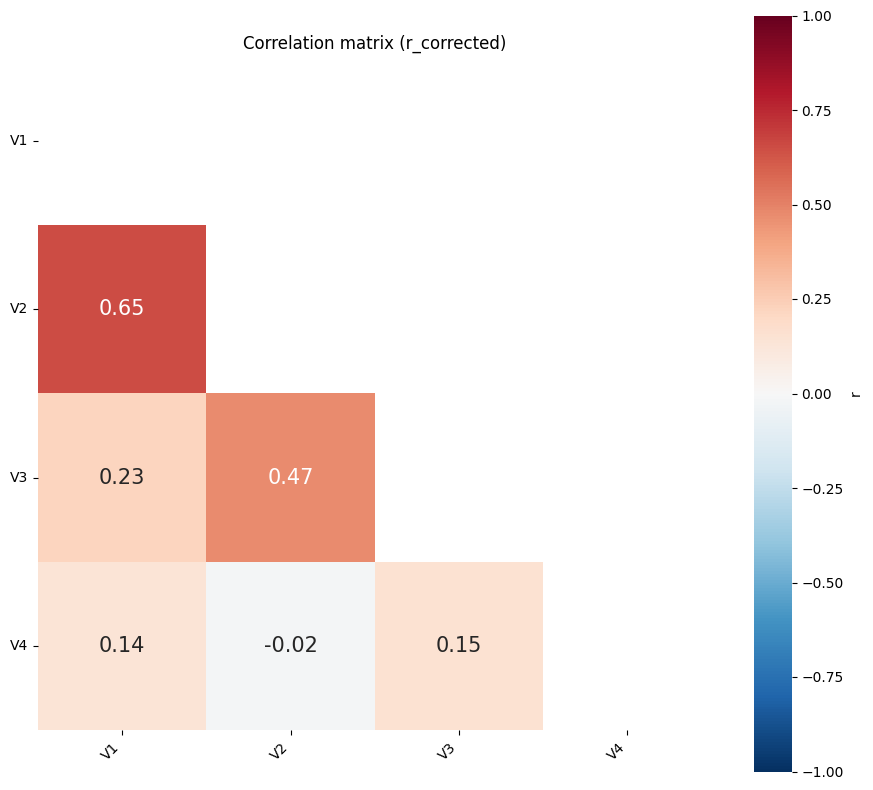

In [74]:
plot_corr_heatmap(corr_mtx_allthresh, value_col="r_measured", fontSize=15)
plot_corr_heatmap(corr_mtx_allthresh, value_col="r_corrected", fontSize=15)